In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import tensorflow as tf
from tensorflow import keras
import cv2
from glob import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random

# import fwr13y.d9m.tensorflow as tf_determinism
tf.keras.utils.set_random_seed(1)
# tf_determinism.enable_determinism()

tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
image_shape = (224, 224)
NUM_CLASSES = 5
BATCH_SIZE = 10
IMG_SIZE = image_shape[0]
VAL_SPLIT = 0.2

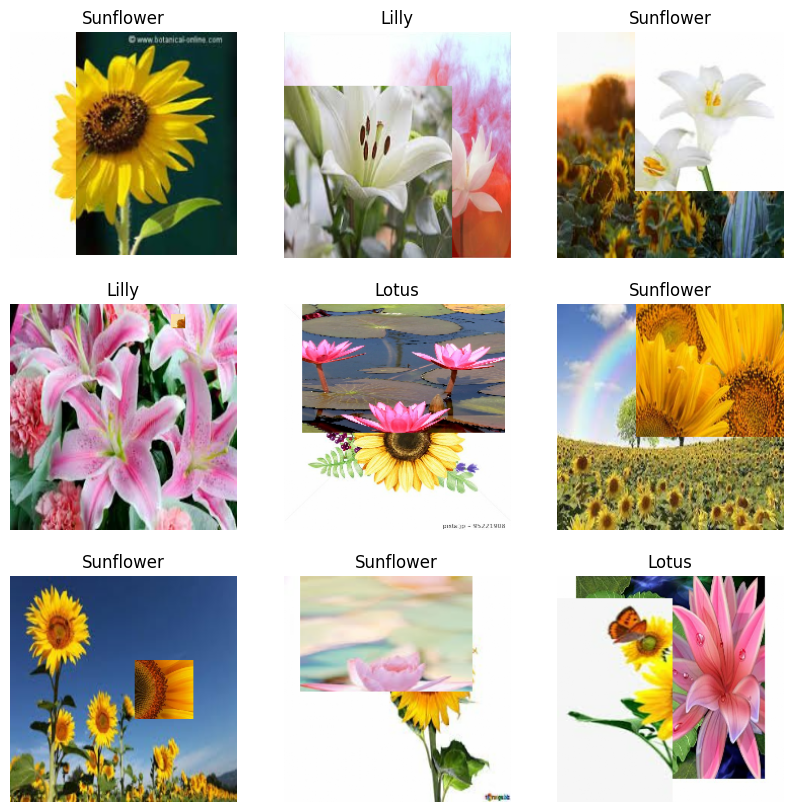

In [3]:
from data_loader import DataSet

dataset = DataSet(dataset_dir='flower_images')
train_data, val_data = dataset(validation_split=0.2)
t1 = train_data.map(lambda x, y: (x, y))
t2 = train_data.map(lambda x, y: (x, y))
td = tf.data.Dataset.zip((t1, t2))
train_ds_cmu = td.map(dataset.cutmix, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_ds = val_data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

import matplotlib.pyplot as plt
import numpy as np

image_batch, label_batch = next(iter(train_ds_cmu))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.title(dataset.class_names[np.argmax(label_batch[i].numpy())])
    plt.imshow(image_batch[i])
    plt.axis("off")
plt.show()

In [7]:
data_augmentation = keras.Sequential([
    # keras.layers.Rescaling(scale=1./255.0, offset=0),
    keras.layers.RandomFlip(),
    keras.layers.RandomRotation(0.20)
])

In [4]:
def ConvMixer(dim: int, patch_size: int, depth: int, kernel_size: int, num_classes: int):
    
    input = keras.Input(shape=image_shape + (3,))
    
    # input = data_augmentation(input)
    x = keras.layers.Conv2D(filters=dim, kernel_size=patch_size, strides=patch_size)(input)
    x = keras.layers.Activation('gelu')(x)
    x1 = keras.layers.BatchNormalization()(x)
    
    for i in range(depth):
        x = keras.layers.DepthwiseConv2D(kernel_size=kernel_size, padding="same")(x1)
        # x = keras.layers.Conv2D(filters=dim, kernel_size=kernel_size, padding='same', groups=dim, activation='gelu')(x1)
        x = keras.layers.Activation('gelu')(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.add([x1, x])
        
        x = keras.layers.Conv2D(filters=dim, kernel_size=1)(x)
        x = keras.layers.Activation('gelu')(x)
        x1 = keras.layers.BatchNormalization()(x)
    
    x = keras.layers.GlobalAvgPool2D()(x1)
    x = keras.layers.Flatten()(x)
    output = keras.layers.Dense(units=num_classes, activation='softmax')(x)
    
    
    return keras.Model(input, output)

In [5]:
convmixer = ConvMixer(dim=512, depth=12, patch_size=7, kernel_size=8, num_classes=5)

In [13]:
model = keras.Sequential([data_augmentation, convmixer])
model.build(input_shape=(None, ) + image_shape + (3,))

In [15]:
model.summary(expand_nested=True)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (224, 224, 3)             0         
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| random_flip (RandomFlip)   (224, 224, 3)             0        |
|                                                               |
| random_rotation (RandomRo  (224, 224, 3)             0        |
| tation)                                                       |
¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯
 model (Functional)          (None, 5)                 3680773   
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| input_1 (InputLayer)       [(None, 224, 224, 3)]     0        |
|                                                               |
| conv2d (Conv2D)            (None, 32, 32, 512)       75776    |
|                                                     

In [17]:
callbacks = [
    keras.callbacks.TensorBoard(), 
    keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5),
    keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=15),
    keras.callbacks.ModelCheckpoint(filepath='checkpoints/convmixer-512-12.keras', save_best_only=True, save_weights_only=True, monitor='val_accuracy'),
    ]

In [18]:
model.compile(
    loss=keras.losses.CategoricalCrossentropy(), 
    optimizer=keras.optimizers.Adam(learning_rate=0.001), 
    metrics='accuracy',
    )

history = model.fit(train_ds_cmu, epochs=150, batch_size=BATCH_SIZE, validation_data=val_ds, callbacks=callbacks, verbose='auto')

convmixer.save('convmixer__model_512-12.keras')

Epoch 1/150
400/400 [==============================] - 167s 346ms/step - loss: 1.4036 - accuracy: 0.4442 - val_loss: 1.6809 - val_accuracy: 0.2410 - lr: 0.0010
Epoch 2/150
400/400 [==============================] - 143s 352ms/step - loss: 1.3342 - accuracy: 0.4970 - val_loss: 1.6612 - val_accuracy: 0.4420 - lr: 0.0010
Epoch 3/150
400/400 [==============================] - 142s 349ms/step - loss: 1.3015 - accuracy: 0.5263 - val_loss: 1.4147 - val_accuracy: 0.4720 - lr: 0.0010
Epoch 4/150
400/400 [==============================] - 146s 359ms/step - loss: 1.2986 - accuracy: 0.5148 - val_loss: 1.3368 - val_accuracy: 0.4740 - lr: 0.0010
Epoch 5/150
400/400 [==============================] - 147s 360ms/step - loss: 1.2988 - accuracy: 0.5217 - val_loss: 1.2575 - val_accuracy: 0.5530 - lr: 0.0010
Epoch 6/150
400/400 [==============================] - 146s 359ms/step - loss: 1.2675 - accuracy: 0.5447 - val_loss: 1.3205 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/150
400/400 [===================

Text(0.5, 0.98, 'Loss and Accuracy when using CutMix')

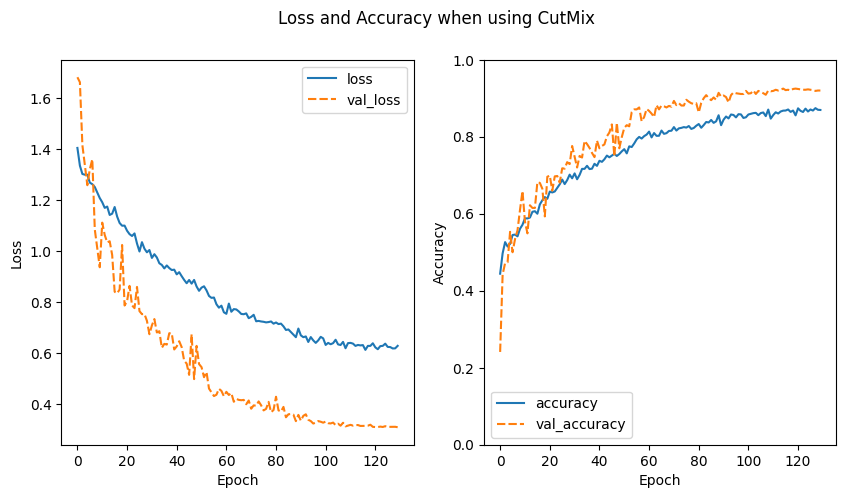

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = sns.lineplot(data={'loss': history.history['loss'], 'val_loss': history.history['val_loss']}, ax=axes[0])
ax.set(xlabel='Epoch', ylabel='Loss')
ax = sns.lineplot(data={'accuracy': history.history['accuracy'], 'val_accuracy': history.history['val_accuracy']}, ax=axes[1])
ax.set(xlabel='Epoch', ylabel='Accuracy', ylim=(0,1))
plt.suptitle("Loss and Accuracy when using CutMix")